## Detecting Tumors With A Deep Convolutional Network 🧠⚕️

### Background

One challenge in modern medicine is identifying tumors and other anomalies on brain MR scans. The goal of developing increasingly sophisticated systems for identifying tumors (and other visible abnormalities) is to aid radiologists in their meticulous searches. In this section, I will create a deep convolutional neural network in order to classify scans as positive (tumorous) or negative (typical).

### Implementation Details

In order to create this model, I downloaded the _Br35H :: Brain Tumor Detection 2020_ image dataset published on Kaggle (https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection) by Ahmed Hamada. This dataset contains two folders labelled "yes" (positive) and "no" (negative), each containing 1500 images of axial slices taken from MR scans. I will segment two-thirds of the data (2000 images) into a training set, and the rest will be placed in the test set. Only one model will be used (for simplicity), so no validation set is required.

### Preparing the Data

In [1]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.metrics import auc, roc_curve, balanced_accuracy_score
from skimage.transform import resize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

%matplotlib inline
%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi'] = 200

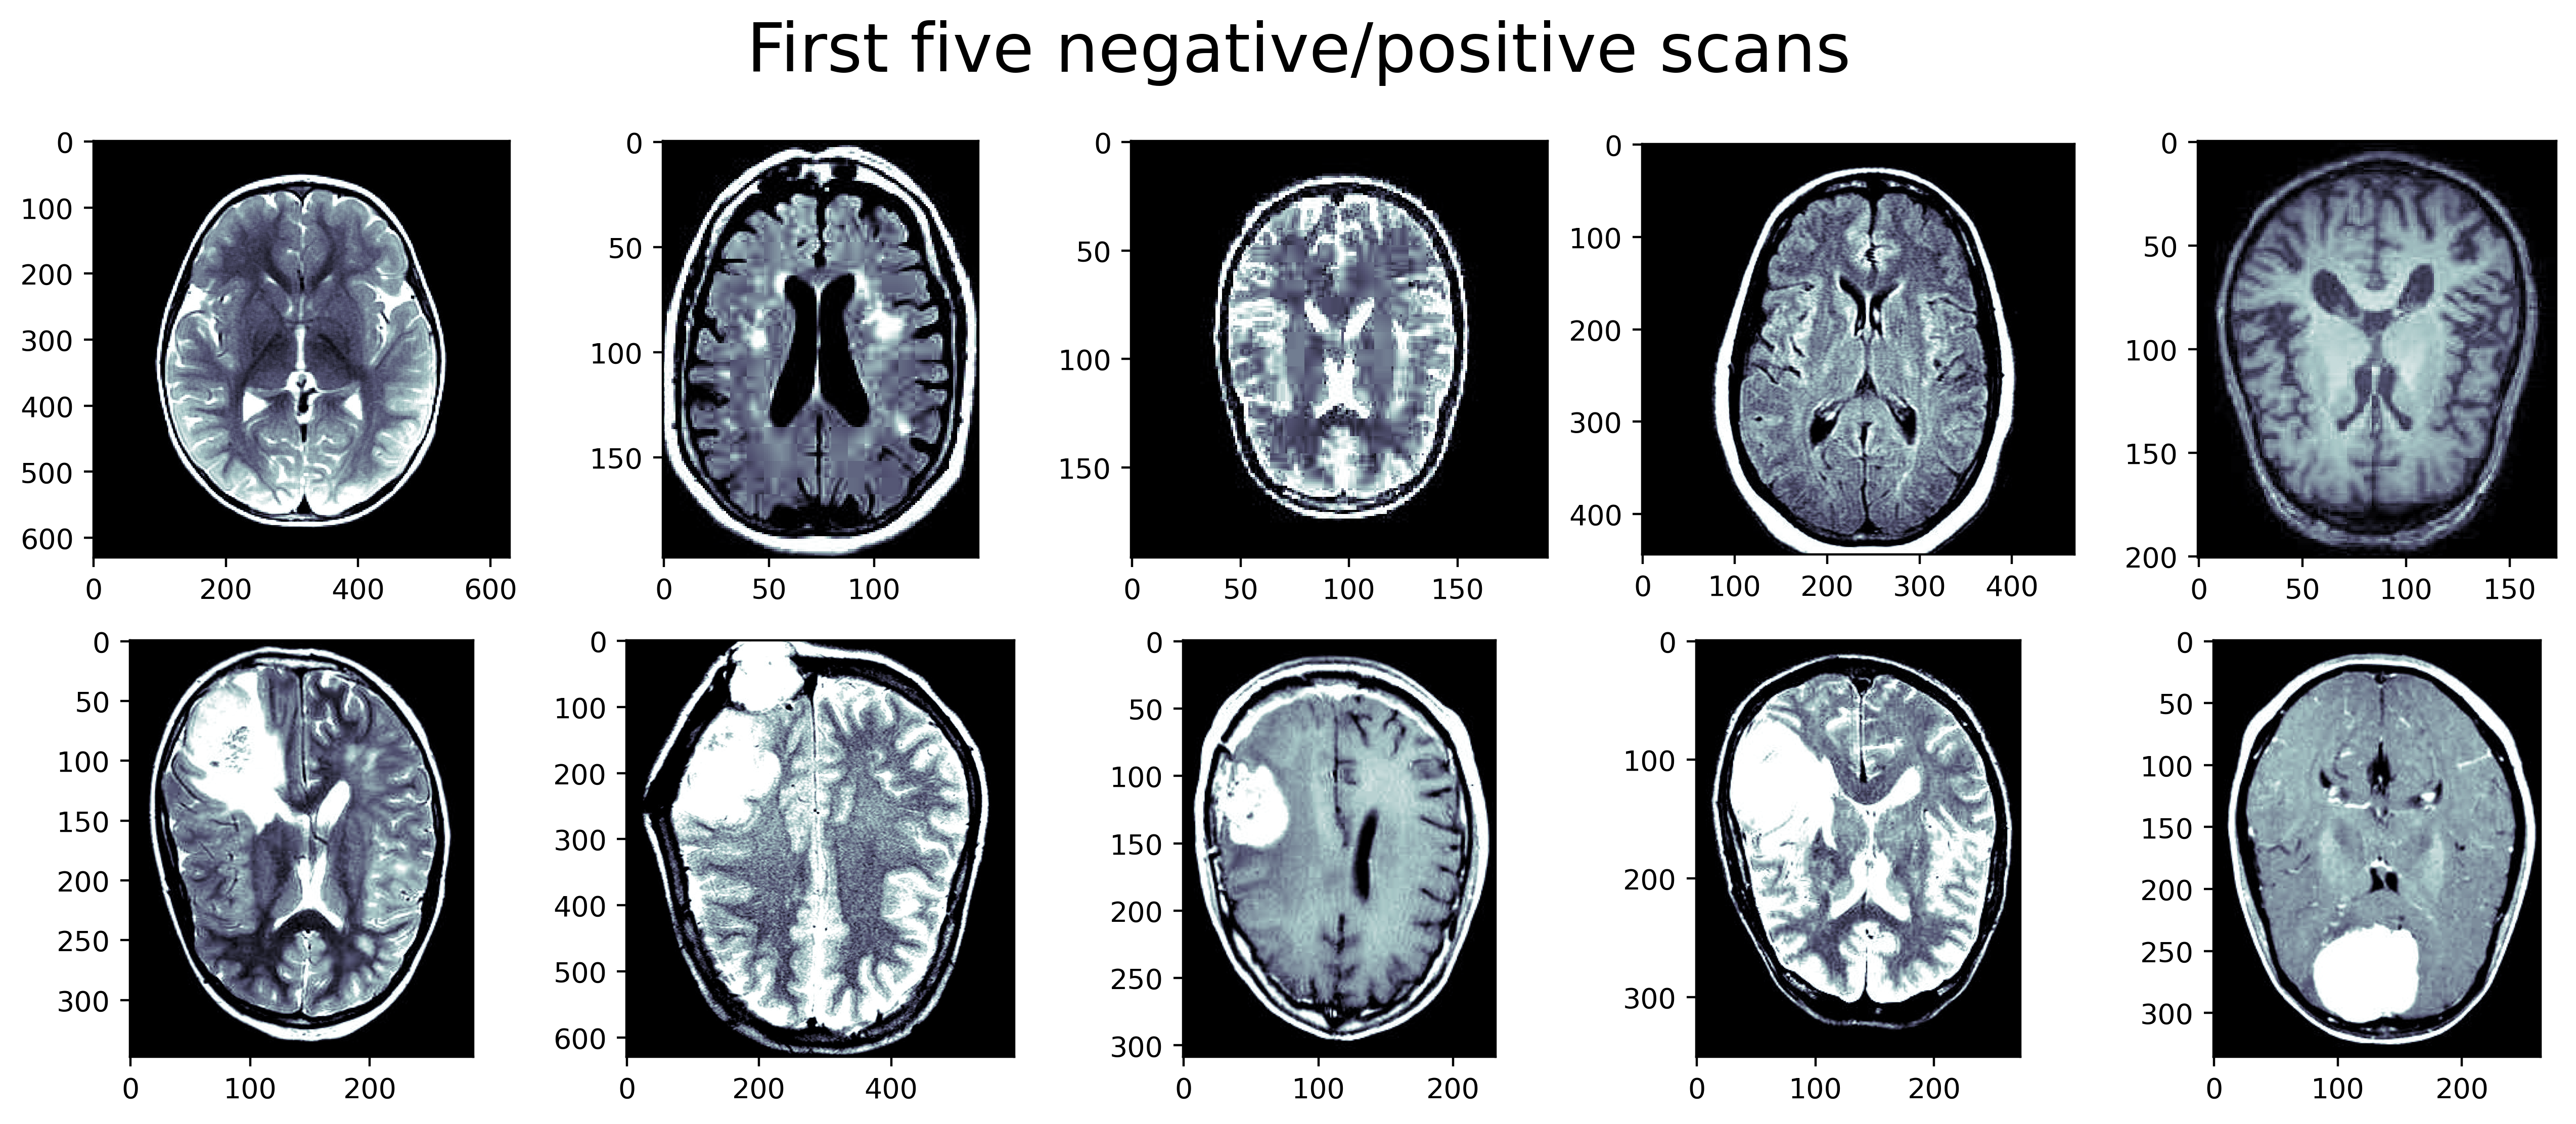

In [2]:
# Load the data
no = [plt_img.imread(f'Br35H/no/no{i}.jpg') for i in range(1500)]
yes = [plt_img.imread(f'Br35H/yes/y{i}.jpg') for i in range(1500)]

# Convert each image to normalized grayscale (we can assume no alpha from .jpg)
for i in range(1500):
    if len(no[i].shape) == 3:
        no[i] = np.mean(no[i], axis=(-1,)) / 255
    if len(yes[i].shape) == 3:
        yes[i] = np.mean(yes[i], axis=(-1,)) / 255

# Peak at first five scans from each category
fig, axs = plt.subplots(2, 5, figsize=(16,6))
fig.suptitle('First five negative/positive scans', fontsize=24)

for i in range(5):
    axs[0,i].imshow(no[i], cmap='bone')
    axs[1,i].imshow(yes[i], cmap='bone')

In [3]:
# These images could clearly use some cleanup;
# We will make each image square, then scale it to match the size of the smallest image
data = []

def padded(img):
    r, c = img.shape
    if r == c:
        return img
    elif r > c:
        left = (r - c) // 2
        right = r - c - left
        return np.pad(img, [(0,0), (left, right)])
    else:
        top = (c - r) // 2
        bot = c - r - top
        return np.pad(img, [(top, bot), (0,0)])

for img in no:
    sq_img = padded(img)
    data += [[sq_img, False]]

for img in yes:
    sq_img = padded(img)
    data += [[sq_img, True]]

min([x[0].shape[0] for x in data])

175

In [4]:
# Since the smallest size is 175 x 175, we will resize all images to match this
X = []
y = []

# We will introduce a categorical encoding for outputs:
# negative -> [0,1], positive -> [1,0]
for img,cat in data:
    X += [img if img.shape[0] == 175 else resize(img, (175, 175))]
    y += [[1 * cat, 1 - 1 * cat]]
    
# Make into NumPy arrays with input channel added to shape
X = np.array(X)[:,:,:,None]
y = np.array(y)

# Finally, we will shuffle the data and create training and test sets
indices = list(range(3000))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

train_X, train_y = X[:2000], y[:2000]
test_X, test_y = X[2000:], y[2000:]

### Building & Training the Model

When we finally build our model, we identify increasingly high-level features with a series of convolutional layers, followed by a sudden dimensionality reduction, and we feed this into our output layer. The output layer consists of two units with a softmax activation for our categorical data, which is accompanied by an appropriate binary cross-entropy loss function. For our dimensionality-reduction layers, we include regularization penalties to ensure that parameters do not grow too large.

In [5]:
model1 = Sequential([
    layers.Input((175, 175, 1)),
    layers.Conv2D(64, (3,3)),
    layers.Conv2D(32, (5,5)),
    layers.Conv2D(16, (5,5)),
    layers.Conv2D(8, (7,7), strides=(2,2)),
    layers.Conv2D(4, (7,7), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(50, activation='relu',
                 kernel_regularizer='l2', bias_regularizer='l2'),
    layers.Dense(2, activation='softmax')
], 'Tumor-Detector')

model1.compile(optimizer='adam', loss='binary_crossentropy')
model1.summary()

Model: "Tumor-Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 169, 169, 32)      51232     
                                                                 
 conv2d_2 (Conv2D)           (None, 165, 165, 16)      12816     
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 8)         6280      
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 4)         1572      
                                                                 
 flatten (Flatten)           (None, 5476)              0         
                                                                 
 dense (Dense)               (None, 50)             

In [6]:
model1.fit(train_X, train_y, batch_size=64, epochs=3)

Epoch 1/3
32/32 [==============================] - 238s 7s/step - loss: 1.6663
Epoch 2/3
32/32 [==============================] - 225s 7s/step - loss: 1.0909
Epoch 3/3
32/32 [==============================] - 236s 7s/step - loss: 0.7652


### Testing the Model

Now that we have constructed our model and fitted it to the training set, we will put it to the test! We will compute the area under the receiver operating characteristic (ROC) curve and the maximum balanced accuracy of the model on the test set.

32/32 [==============================] - 18s 546ms/step


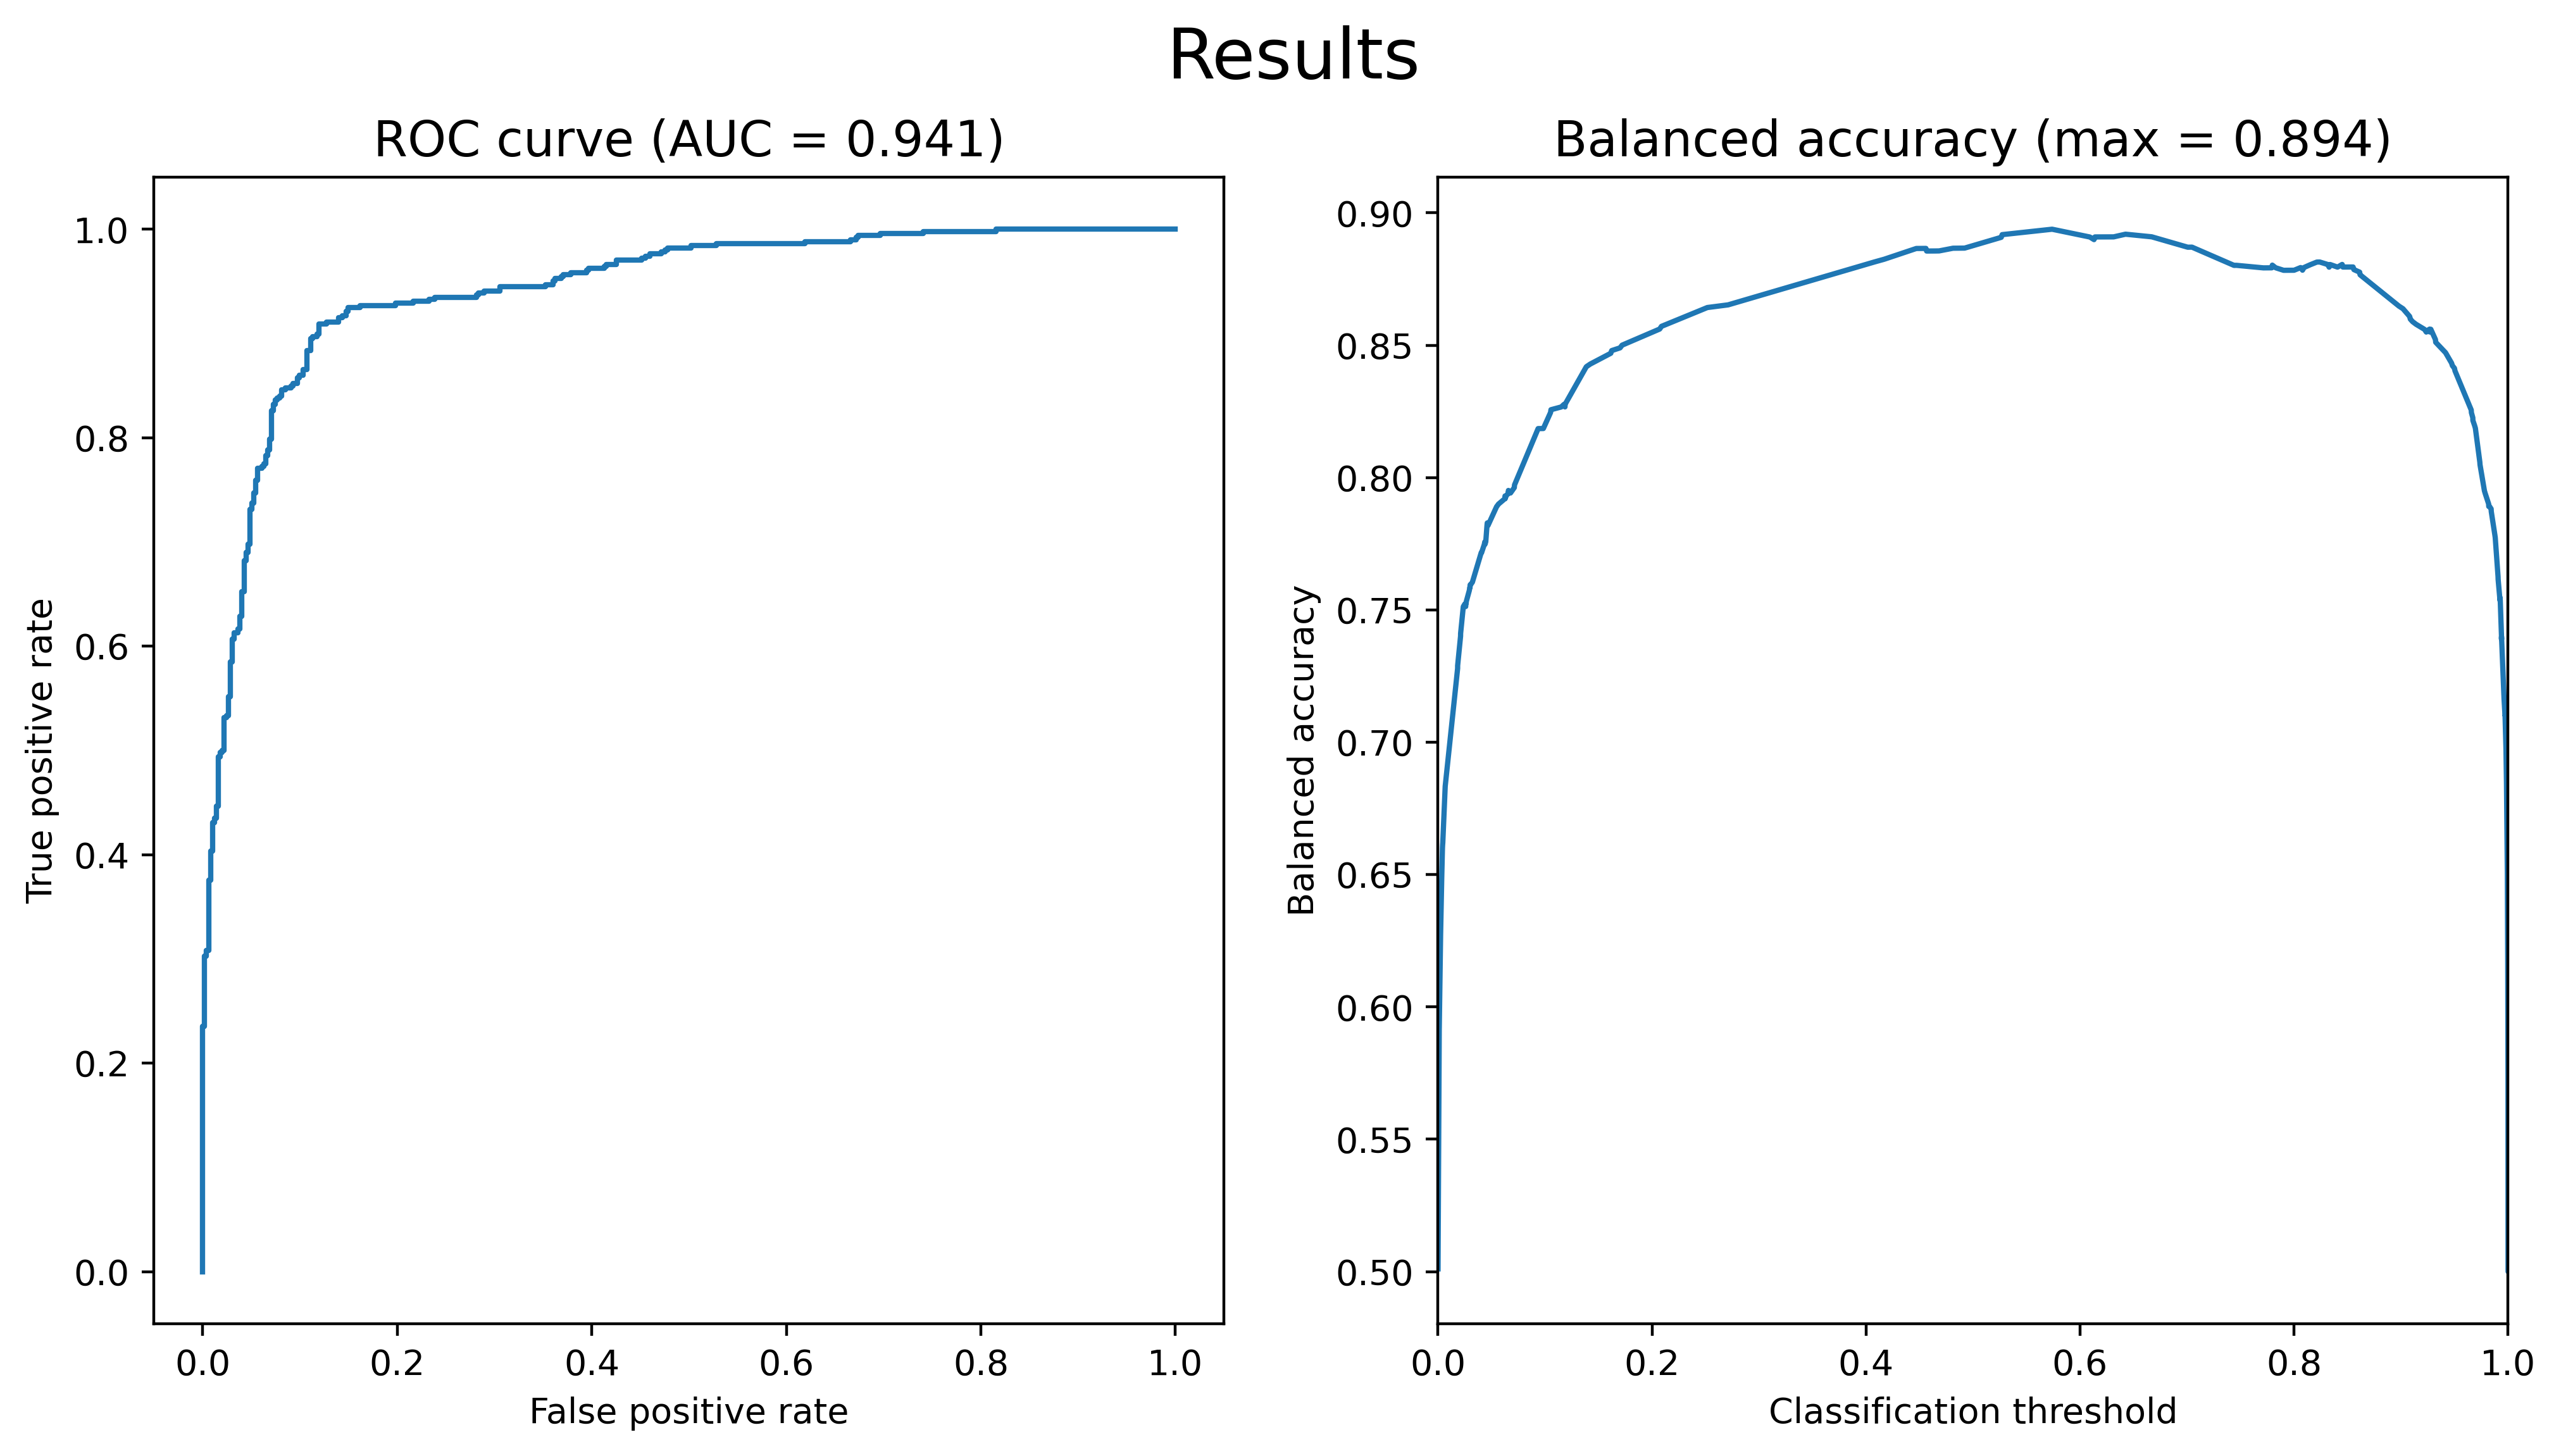

In [7]:
# make predictions on test set
pred = model1.predict(test_X)

# compute ROC and corresponding AUC
fpr, tpr, thresholds = roc_curve(test_y[:,0], pred[:,0])
auc_roc = auc(fpr, tpr)

# balanced accuracy for classification threshold t
def bal_acc(t):
    return balanced_accuracy_score(test_y[:,0], pred[:,0] > t)

# vectorize the function with numpy and find maximizing threshold
bal_acc = np.vectorize(bal_acc)
scores = bal_acc(thresholds)
max_idx = np.argmax(scores)
max_thresh = thresholds[max_idx]
max_score = scores[max_idx]

# plot ROC curve and balanced accuracy by threshold
fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Results', fontsize=20)

axs[0].set_title(f'ROC curve (AUC = {auc_roc:.3f})', fontsize=14)
axs[0].plot(fpr, tpr)
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')

axs[1].set_title(f'Balanced accuracy (max = {max_score:.3f})', fontsize=14)
axs[1].plot(thresholds, scores)
axs[1].set_xlabel('Classification threshold')
axs[1].set_ylabel('Balanced accuracy')
axs[1].set_xlim([0,1])

plt.show()

As we can see, the area under the ROC curve is greater than 0.9, indicating that for any given classification threshold, the true positive rate (TPR) is far greater than the false positive rate (FPR). This means that for a wide range of classification thresholds, the accuracy on the testing set is relatively high, which we can see in the neighboring graph.

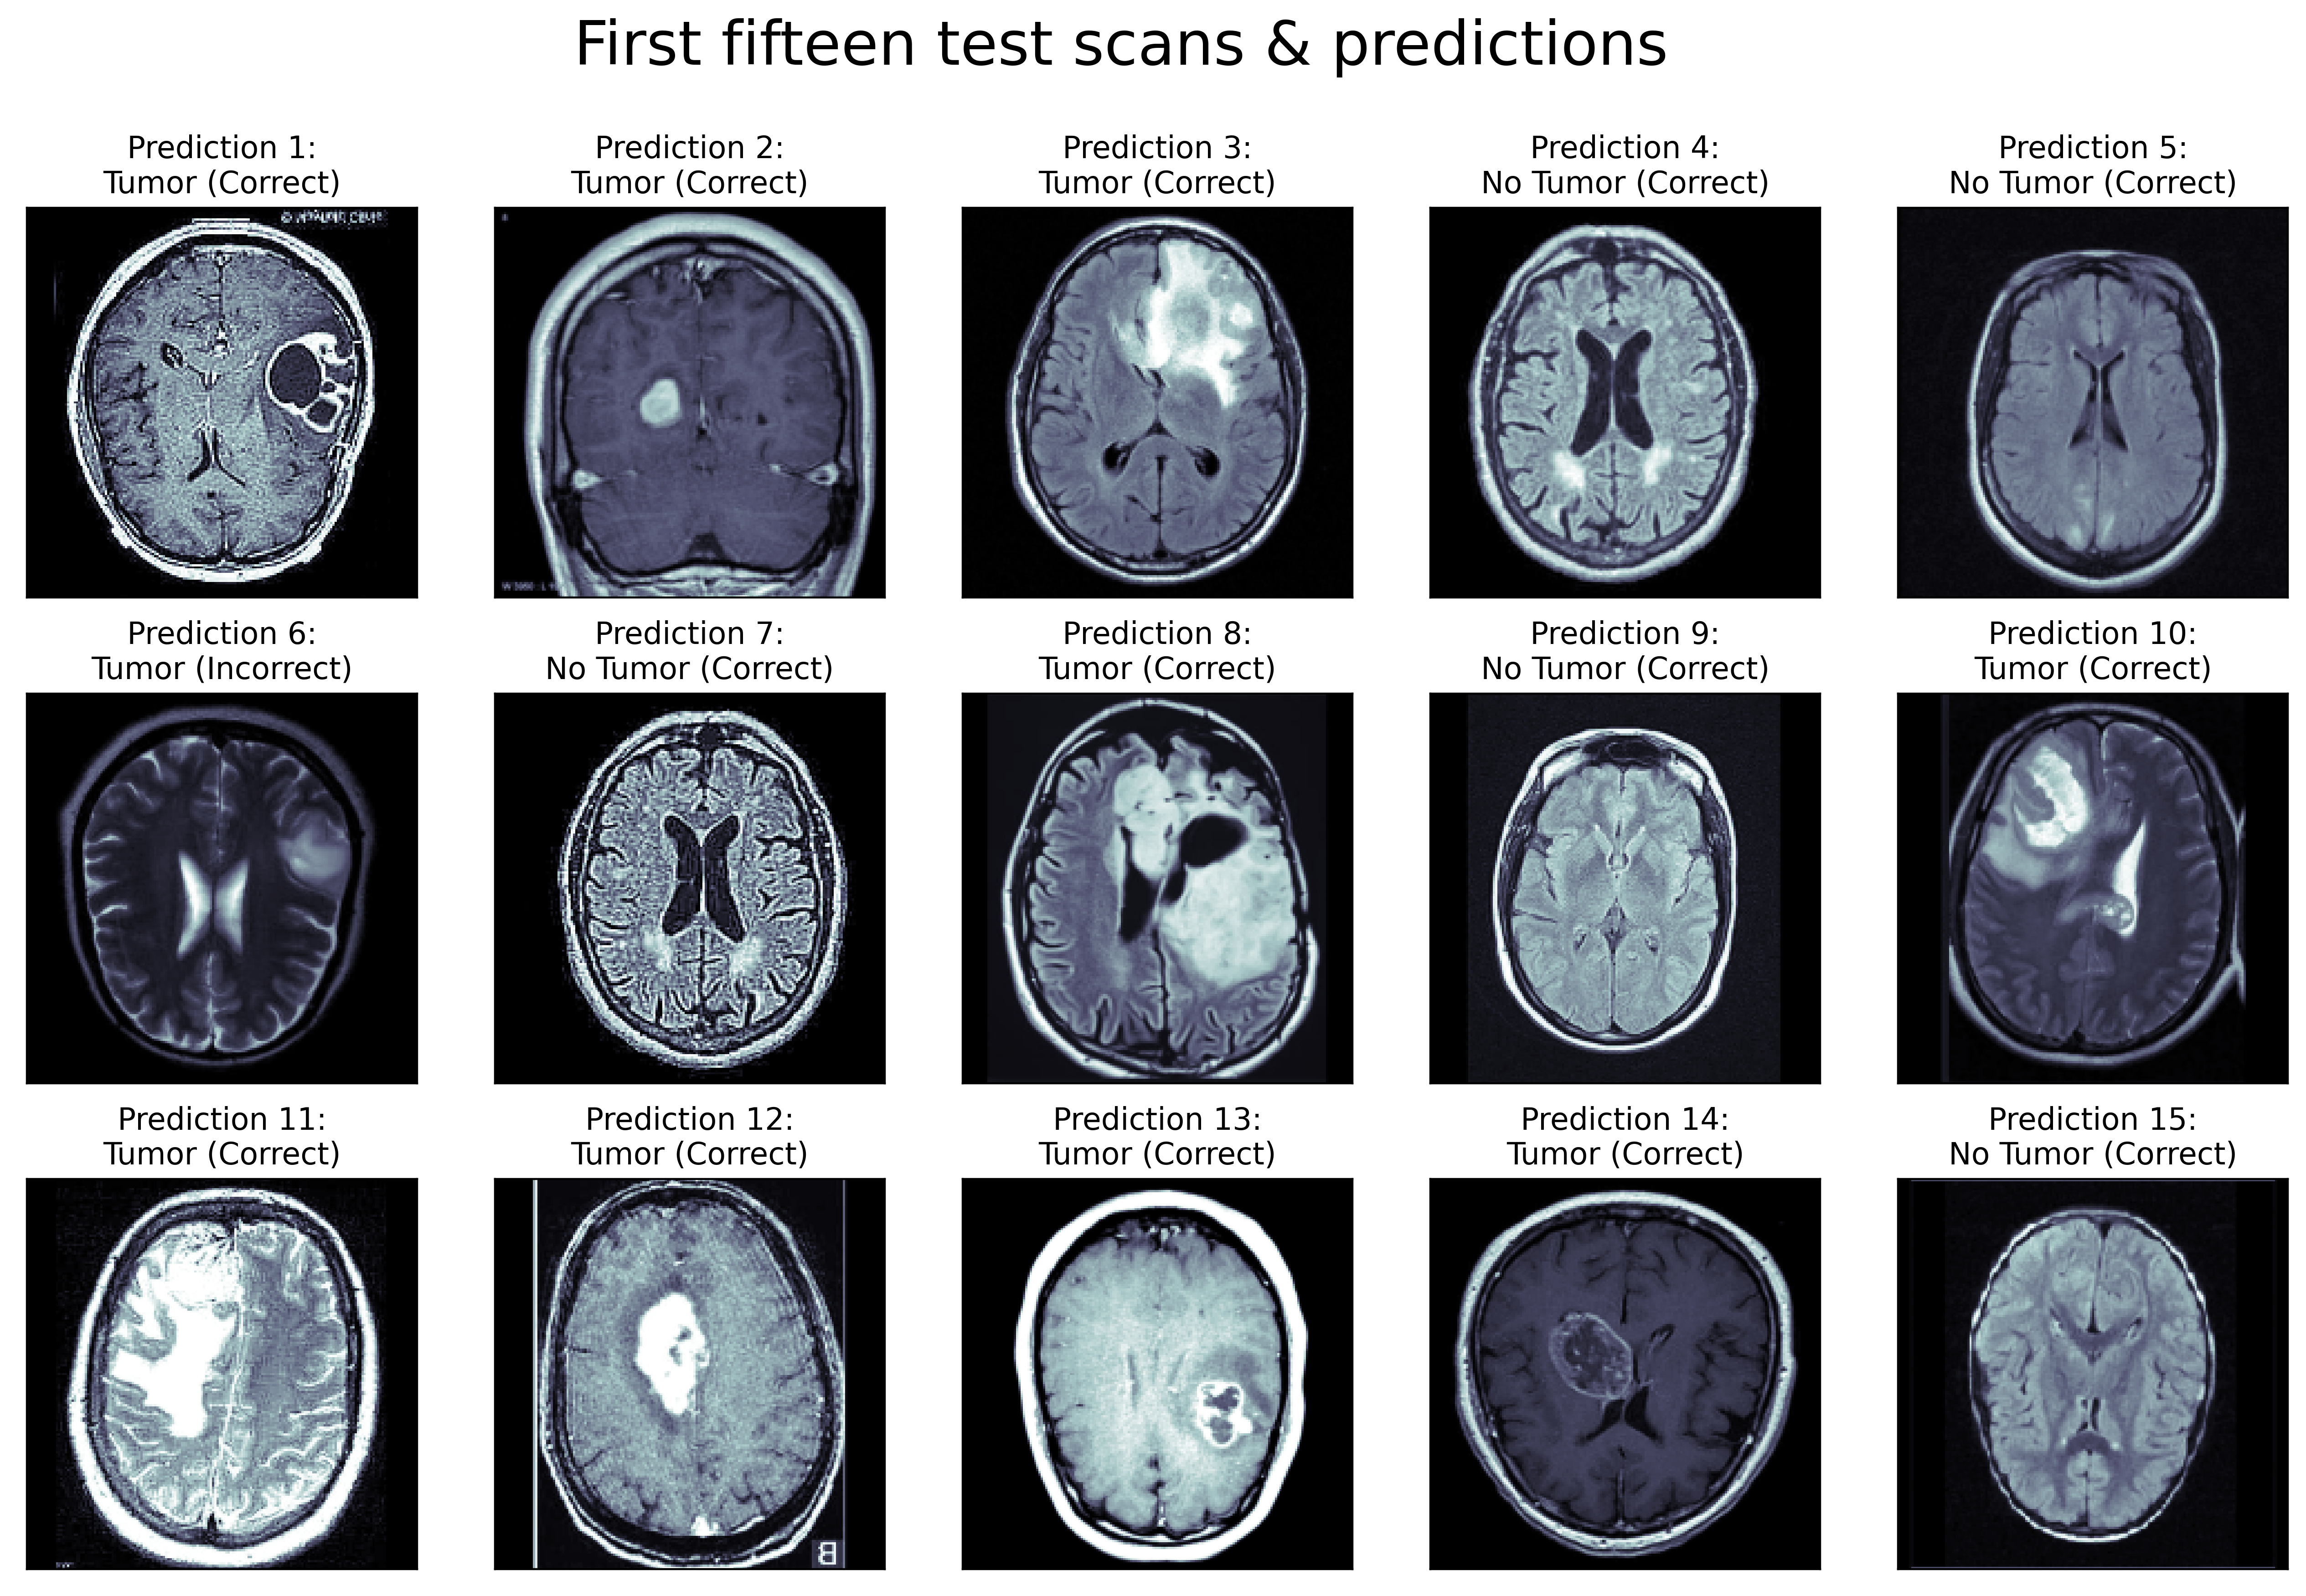

In [8]:
# peek at first 15 scans from test set and predictions
fig, axs = plt.subplots(3, 5, figsize=(16,10))
fig.suptitle('First fifteen test scans & predictions', fontsize=24)

# get best predictions
max_pred = pred[:,0] > max_thresh

for i in range(15):
    tumor = 'Tumor' if max_pred[i] else 'No Tumor'
    corr = 'Correct' if max_pred[i] == test_y[i,0] else 'Incorrect'
    axs[i//5, i%5].imshow(test_X[i,:,:,0], cmap='bone')
    axs[i//5, i%5].set_title(f'Prediction {i+1}:\n{tumor} ({corr})', fontsize=12)
    axs[i//5, i%5].set_xticks([])
    axs[i//5, i%5].set_yticks([])